<a href="https://colab.research.google.com/github/kundajelab/poissonloss/blob/master/InvestigatePoissonLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#get the data
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_simulation.simdata.gz
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_neg_labels.txt.gz
!wget https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_pos_labels.txt.gz

--2020-06-11 21:48:47--  https://github.com/kundajelab/feature_interactions/raw/f761fd8/av/data/train_simulation.simdata.gz
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/f761fd8182c19931c16f7e3a5e562394dce443d2/av/data/train_simulation.simdata.gz [following]
--2020-06-11 21:48:48--  https://raw.githubusercontent.com/kundajelab/feature_interactions/f761fd8182c19931c16f7e3a5e562394dce443d2/av/data/train_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2104123 (2.0M) [application/octet-stream]
Saving to: ‘train_simulation.simdata.gz’

train_simulati

In [3]:
!gunzip *.gz

gzip: train_neg_labels.txt already exists; do you wish to overwrite (y or n)? y
gzip: train_pos_labels.txt already exists; do you wish to overwrite (y or n)? y
gzip: train_simulation.simdata already exists; do you wish to overwrite (y or n)? y


In [4]:
!md5sum *

md5sum: colab_notebook_data: Is a directory
md5sum: drive: Is a directory
md5sum: sample_data: Is a directory
1f2ddf5f3a74e3db548c5d2180d29a45  train_neg_labels.txt
262ca284f5f8676b16c8bf92047cfe70  train_pos_labels.txt
fb82dd3c7dc4b53d34b4fd456394de42  train_simulation.simdata


In [5]:
!pip install simdna

In [0]:
import simdna
from simdna import synthetic

In [0]:
train_data = synthetic.read_simdata_file("train_simulation.simdata")

In [0]:
import numpy as np


#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


#No anscombe transform this time
def read_labels_and_oracle(filename):
  labels = np.array([float(x.split("\t")[0]) for
                                          x in open(filename)])
  oracle = np.array([float(x.split("\t")[1]) for
                                          x in open(filename)])
  return labels, oracle


train_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in train_data.sequences])

train_pos_labels, train_pos_oracle =\
  read_labels_and_oracle("train_pos_labels.txt")
train_neg_labels, train_neg_oracle =\
  read_labels_and_oracle("train_neg_labels.txt")

In [9]:
#define model architectures

import keras
import string
import random
from keras import backend as K
import tensorflow.compat.v1 as tf

def pcpoisson(y_true, y_pred):
  return K.mean((y_pred+0.1) - (y_true+0.1)*K.log(y_pred+0.1), axis=-1)


def model_arch1(loss, finalactivation):
  model = keras.models.Sequential()
  for i in range(4):
    added_kwarg = {}
    if (i==0):
      added_kwarg["input_shape"] = (100,4)
    model.add(keras.layers.Conv1D(
                filters=30, kernel_size=7, 
                activation = "relu",
                kernel_initializer="he_normal",
                **added_kwarg))
  model.add(keras.layers.GlobalAveragePooling1D()) 
  for i in range(2):
    model.add(keras.layers.Dense(50, activation="relu",
              kernel_initializer="he_normal"))
  model.add(keras.layers.Dense(1, activation=finalactivation,
                               kernel_initializer="he_normal"))
  #equivalent to scaling down output by 100
  #model.add(keras.layers.Lambda(lambda x: x*100))
  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss=loss, metrics=["poisson", "mse"])
  return model


def train_and_save_model(model_constructor, prefix, X_train, y_train,
                         X_valid, y_valid, seed):
  
  barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
  np.random.seed(seed)
  tf.set_random_seed(seed)
  model = model_constructor()
  save_filename = prefix+"_"+barcode+".h5"
  print("Training model", save_filename)
  print(model.summary())
  history = model.fit(x=X_train, y=y_train, batch_size=200,
              epochs=50,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(
                          monitor='val_loss',
                          patience=15,
                          restore_best_weights=True)])  
  print("Save file name", save_filename)
  model.save(save_filename)
  return model, history, prefix, barcode


Using TensorFlow backend.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ln -s /content/drive/My\ Drive/colab_notebook_data/ .

ln: failed to create symbolic link './colab_notebook_data': File exists


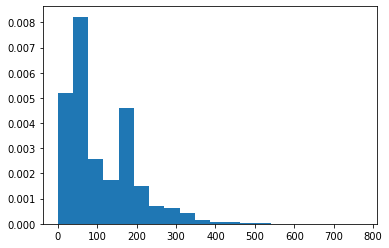

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(train_pos_labels, density=True, bins=20)
plt.show()

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed100_wpevh.h5
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_133 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_34  (None, 30)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)               

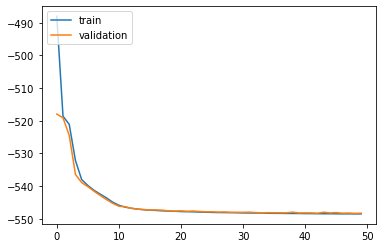

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-relu_seed100_dornu.h5
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_137 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_35  (None, 30)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 50)                155

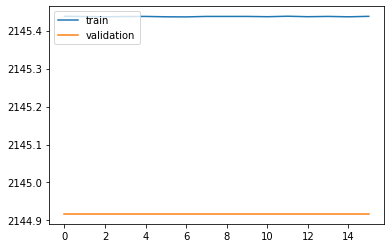

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-softplus_seed100_rjpsz.h5
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_141 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_36  (None, 30)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 50)             

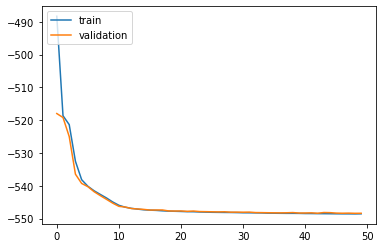

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-relu_seed100_uypmr.h5
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_145 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_146 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_147 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_148 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_37  (None, 30)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 50)                1

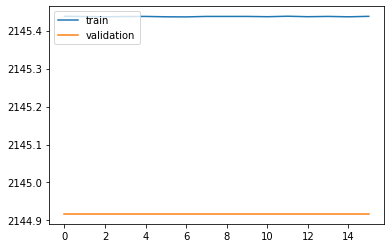

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed200_xggef.h5
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_149 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_150 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_38  (None, 30)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 50)               

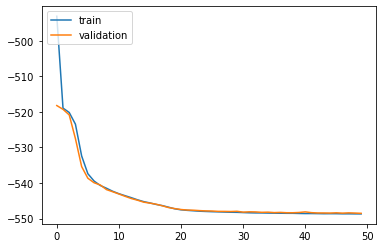

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-relu_seed200_rojaa.h5
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_153 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_39  (None, 30)                0         
_________________________________________________________________
dense_115 (Dense)            (None, 50)                155

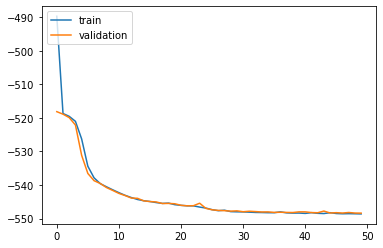

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-softplus_seed200_aywdz.h5
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_157 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_40  (None, 30)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 50)             

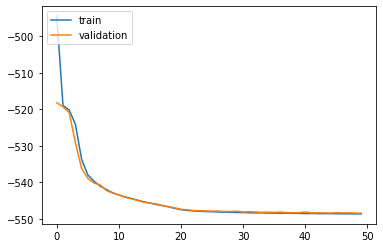

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-relu_seed200_oedfg.h5
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_161 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_41  (None, 30)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 50)                1

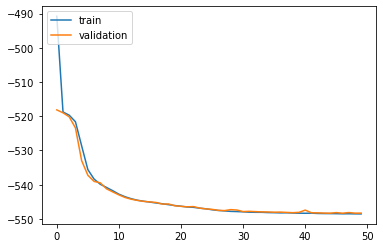

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed300_lzrnd.h5
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_165 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_166 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_168 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_42  (None, 30)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 50)               

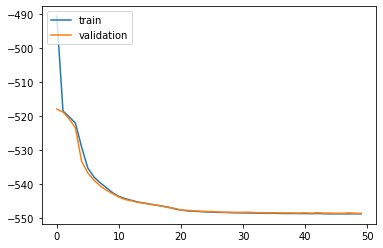

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-relu_seed300_hgrtx.h5
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_169 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_43  (None, 30)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 50)                155

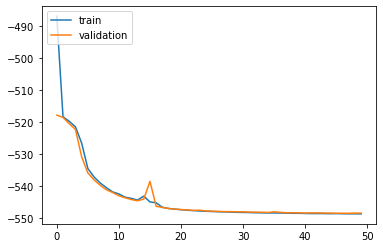

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-softplus_seed300_usayw.h5
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_173 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_44  (None, 30)                0         
_________________________________________________________________
dense_130 (Dense)            (None, 50)             

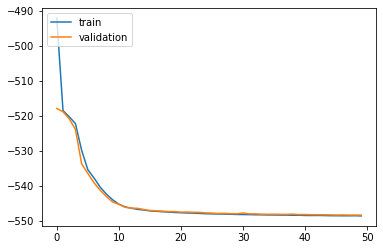

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-relu_seed300_hzssp.h5
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_177 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_178 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_179 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_180 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_45  (None, 30)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 50)                1

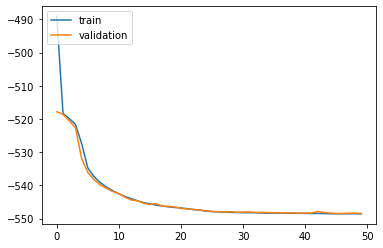

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed400_eyuoc.h5
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_181 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_46  (None, 30)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 50)               

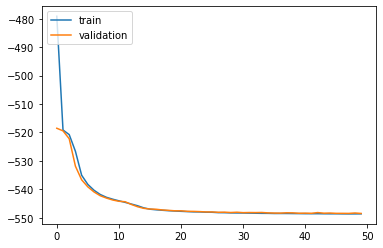

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-relu_seed400_qtusy.h5
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_185 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_187 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_188 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_47  (None, 30)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 50)                155

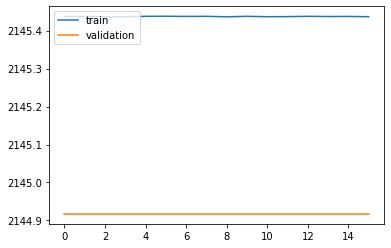

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-softplus_seed400_fnvzr.h5
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_189 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_190 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_191 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_192 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_48  (None, 30)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 50)             

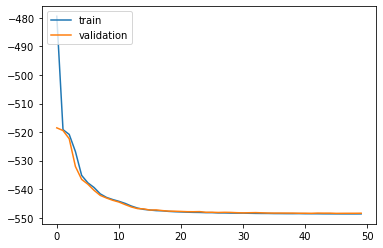

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-relu_seed400_ufhfx.h5
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_193 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_194 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_49  (None, 30)                0         
_________________________________________________________________
dense_145 (Dense)            (None, 50)                1

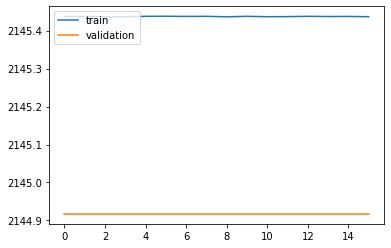

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed500_aqgac.h5
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_197 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_198 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_199 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_50  (None, 30)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 50)               

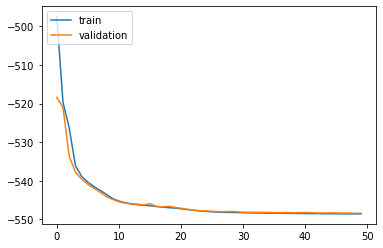

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-relu_seed500_xhwlv.h5
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_201 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_202 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_204 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_51  (None, 30)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 50)                155

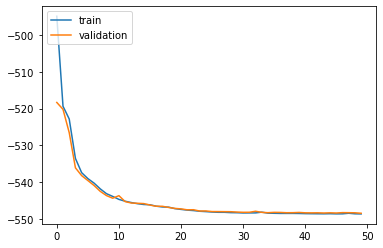

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-softplus_seed500_xkizt.h5
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_205 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_52  (None, 30)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 50)             

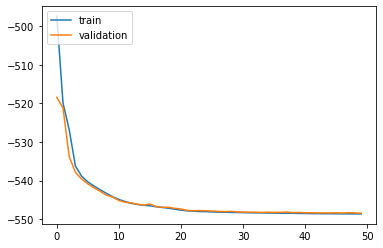

Training model colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-pcpoisson_finalact-relu_seed500_iceje.h5
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_209 (Conv1D)          (None, 94, 30)            870       
_________________________________________________________________
conv1d_210 (Conv1D)          (None, 88, 30)            6330      
_________________________________________________________________
conv1d_211 (Conv1D)          (None, 82, 30)            6330      
_________________________________________________________________
conv1d_212 (Conv1D)          (None, 76, 30)            6330      
_________________________________________________________________
global_average_pooling1d_53  (None, 30)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 50)                1

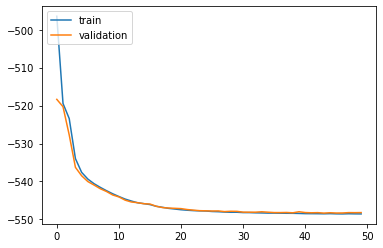

In [53]:
#train the models
from collections import defaultdict
from matplotlib import pyplot as plt

indices_train = np.arange(0, int(0.8 * train_onehot_data.shape[0]))
indices_valid = np.arange(int(0.8 * train_onehot_data.shape[0]),
                              train_onehot_data.shape[0])

SAVEDIR = "colab_notebook_data/feature_interactions/trained_models"

modeltype_to_histories = defaultdict(list)

for seed in [100, 200, 300, 400, 500]:
  for model_constructor, archname in [(model_arch1, 'arch1')]:
    for loss,lossname in [("poisson", "poisson"),
                          (pcpoisson, "pcpoisson")]:
        for finalact in ["softplus", "relu"]:               
          model, history, prefix, barcode = train_and_save_model(
              model_constructor=lambda: model_constructor(
                  loss=loss, finalactivation=finalact),
              prefix=(SAVEDIR+"/model-"+archname
                      +"_loss-"+str(lossname)
                      +"_finalact-"+finalact
                      +"_seed"+str(seed)),
              X_train=train_onehot_data[indices_train],
              y_train=train_neg_labels[indices_train],
              X_valid=train_onehot_data[indices_valid],
              y_valid=train_neg_labels[indices_valid],
              seed=seed) #vary the seed for initialization diversity
          modeltype_to_histories[archname+"_"+lossname].append(history)
          print(prefix,barcode)
          plt.plot(history.history["poisson"])
          plt.plot(history.history["val_poisson"])
          plt.legend(['train', 'validation'], loc='upper left')
          plt.show()

In [0]:
from keras.models import load_model
model = load_model("colab_notebook_data/feature_interactions/trained_models/model-arch1_loss-poisson_finalact-softplus_seed500_aqgac.h5")

In [0]:
def anscombe_transform(vals):
  return 2*np.sqrt(vals + 3.0/8)

In [0]:
import numpy as np

train_preds = np.squeeze(model.predict(train_onehot_data))


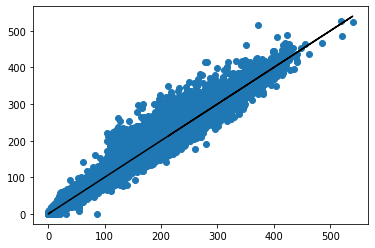

In [37]:
plt.scatter(train_preds, train_neg_labels)
plt.plot(train_preds, train_preds, color="black")
plt.show()

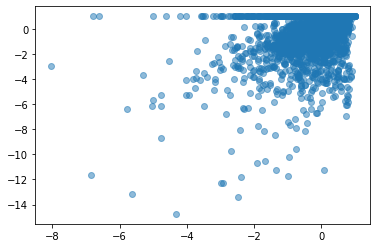

In [49]:
plt.scatter(1 - train_neg_oracle/train_preds,
            1 - train_neg_labels/train_preds, alpha=0.5)
plt.show()

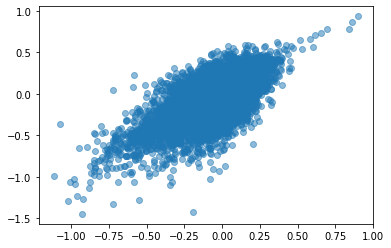

In [54]:
pc = 5
plt.scatter(1 - (train_neg_oracle+pc)/(train_preds+pc),
            1 - (train_neg_labels+pc)/(train_preds+pc), alpha=0.5)
plt.show()

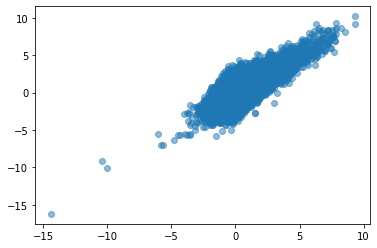

In [33]:
plt.scatter(anscombe_transform(train_neg_oracle)
            -anscombe_transform(train_preds),
            anscombe_transform(train_neg_labels)
            -anscombe_transform(train_preds), alpha=0.5)
plt.show()

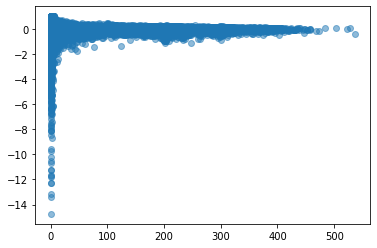

In [29]:
plt.scatter(train_neg_oracle, train_grads, alpha=0.5)
plt.show()

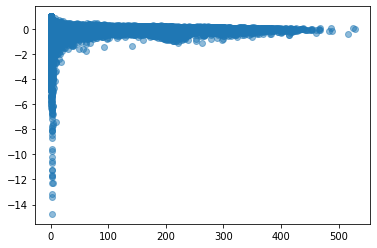

In [26]:
plt.scatter(train_neg_labels, train_grads, alpha=0.5)
plt.show()

In [0]:
valid_preds = np.squeeze(model.predict(train_onehot_data[indices_valid]))

In [0]:
valid_labels = train_neg_labels[indices_valid]

In [62]:
np.mean(np.square(valid_preds-valid_labels))

292.80403739159533

In [65]:
np.mean(np.square(anscombe_transform(valid_preds)-anscombe_transform(valid_labels)))

2.074246551127051

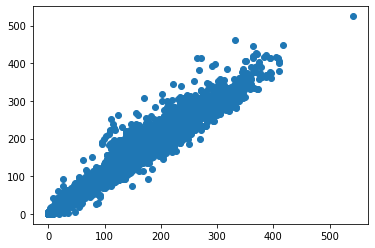

In [58]:
plt.scatter(valid_preds,valid_labels)
plt.show()

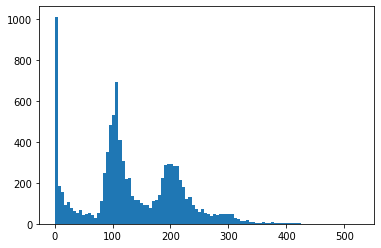

In [57]:
plt.hist(valid_labels, bins=100)
plt.show()